In [1]:
# libraries used
import numpy as np
import pandas as pd
import time

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn import linear_model
from matplotlib import pyplot
from sklearn.feature_selection import SelectFromModel

In [2]:
# importing the merged dataset
data = pd.read_csv('ensembleMean_Spain.csv')

First of all, we split the data set into training and testing in order to get a higher precision of metrics. 

The training part includes the electricity data before year 2018 while the testing set includes the electricity data after 2018. 

In [3]:
# splitting data set into training set and testing set (OUTER)

train = data[data['time']<'2018-01-01 00:00:00'] # trainig set are data from dates before 2018
test = data[data['time']>='2018-01-01 00:00:00'] # testing set are data from dates after 2018

In [4]:
# splitting the sets into variables and response
y_train = train['response']
x_train = train[[x for x in train.columns if (x != 'response') & (x != 'time')]]

y_test = test['response']
x_test = test[[x for x in test.columns if (x != 'response') & (x != 'time')]]

In [5]:
x_test.shape

(2920, 3536)

Then we split the training part into training set and validation set in order to set a custom cross validation method. 

The reason to do so is, it is only possible to use the previous data to predict the future, therefore, we split the data into 3 different times to train the different models. 
- dates before 2017 as the training set;
- dates from 2017-2018 as the validation set (in order to tune the hyperparameters of each single model that we will be using in the project); 
- and the dates after 2018 as the testing set (in order to compare the different metrics for each model that we have trained) 

In [6]:
train[train['time']=='2017-01-01 00:00:00'] # checking the first day of 2017 in order to split training from validation(INNER)

,time,norma_10_36.0_-0.5,norma_10_36.0_-1.0,norma_10_36.0_-1.5,norma_10_36.0_-2.0,norma_10_36.0_-2.5,norma_10_36.0_-3.0,norma_10_36.0_-3.5,norma_10_36.0_-4.0,norma_10_36.0_-4.5,...,v100_44.0_-9.0,v100_44.0_-9.5,v100_44.0_0.0,v100_44.0_0.5,v100_44.0_1.0,v100_44.0_1.5,v100_44.0_2.0,v100_44.0_2.5,v100_44.0_3.0,response
5848,2017-01-01 00:00:00,1.906174,2.611856,3.791657,4.621365,5.310724,6.139571,7.04824,7.666611,7.167265,...,-0.622075,-0.645622,0.578852,0.635822,0.834078,1.299713,1.548102,1.428845,0.800656,111150.249


In [7]:
# Splitting indeces to create a custom cv 

train_indices = list(range(0,5848))                  # dates before 2017 to train
test_indices = list(range(5848, len(train)))         # dates from 2017 to 2018 to validate (INNER)
custom_cv = [(train_indices, test_indices)]

In [8]:
# creating a metrics matrix in order to visualize the different results
df_metricas=pd.DataFrame(columns=['train_R2', 'test_R2', 'train_MAXerror', 'test_MAXerror',
                                 'train_mae', 'test_mae', 'train_mse', 'test_mse', 
                                  'train_rmse', 'test_rmse'], 
                         index=['RF','GB','SVM','lm','lm_all_vars'])

In [9]:
# Metrics for evaluating
def metrics(y_train, pred_train, y_test, pred_test, model):
    # Varianza explicada
    ve_train = explained_variance_score(y_train, pred_train)
    ve_test = explained_variance_score(y_test, pred_test)
    print('explained variance of training set:',(ve_train))
    print('explained variance of testing set:',(ve_test))
    df_metricas.loc[model, 'train_R2']=ve_train
    df_metricas.loc[model, 'test_R2']=ve_test
    # Maximum error
    me_train = max_error(pred_train, y_train)
    me_test = max_error(pred_test, y_test)
    print('maximum error of training set:',(me_train))
    print('maximum error of testing set:',(me_test))
    df_metricas.loc[model, 'train_MAXerror']=me_train
    df_metricas.loc[model, 'test_MAXerror']=me_test
    # mean absolute error: datos mal predichos, no al cuadrado, menor peso
    mae_train = mean_absolute_error(pred_train, y_train)
    mae_test = mean_absolute_error(pred_test, y_test)
    print('mae of training set:',(mae_train))
    print('mae of testing set:',(mae_test))
    df_metricas.loc[model, 'train_mae']=mae_train
    df_metricas.loc[model, 'test_mae']=mae_test
    # mean squared error: al cuadrado 
    # raiz de mse
    mse_train = mean_squared_error(pred_train, y_train)
    mse_test = mean_squared_error(pred_test, y_test)
    print('mse of training set:',(mse_train))
    print('mse of testing set:',(mse_test))
    df_metricas.loc[model, 'train_mse']=mse_train
    df_metricas.loc[model, 'test_mse']=mse_test
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    print('rmse of training set:',(rmse_train))
    print('rmse of testing set:',(rmse_test))
    df_metricas.loc[model, 'train_rmse']=rmse_train
    df_metricas.loc[model, 'test_rmse']=rmse_test

### Linear Model in order to find the best predictors 

In [10]:
from sklearn import linear_model

lm = linear_model.LinearRegression()
lm.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [11]:
lm_pred_train = lm.predict(x_train)
lm_pred_test = lm.predict(x_test)

In [12]:
metrics(y_train, lm_pred_train, y_test, lm_pred_test, 'lm_all_vars')

explained variance of training set: 0.9803943000970495
explained variance of testing set: 0.9250961994990252
maximum error of training set: 184837.26209515252
maximum error of testing set: 396570.1376460153
mae of training set: 21766.85075963782
mae of testing set: 44624.013580208244
mse of training set: 789469611.1516016
mse of testing set: 3325849568.4992523
rmse of training set: 28097.501866742557
rmse of testing set: 57670.17919600434


Feature: 0, Score: 2393.47381
Feature: 1, Score: 3695.45961
Feature: 2, Score: 1344.78841
Feature: 3, Score: -146.56939
Feature: 4, Score: 5196.64684
Feature: 5, Score: -2080.70104
Feature: 6, Score: -646.70533
Feature: 7, Score: 4209.66384
Feature: 8, Score: -5857.91191
Feature: 9, Score: -3436.92834
Feature: 10, Score: 2213.53159
Feature: 11, Score: 4565.86703
Feature: 12, Score: -1508.10446
Feature: 13, Score: 20088.26861
Feature: 14, Score: -22670.23270
Feature: 15, Score: 8522.50619
Feature: 16, Score: -4579.13351
Feature: 17, Score: -22715.37662
Feature: 18, Score: 6359.25617
Feature: 19, Score: 4312.97294
Feature: 20, Score: -5838.11654
Feature: 21, Score: 6782.20047
Feature: 22, Score: 2515.41193
Feature: 23, Score: -5594.74932
Feature: 24, Score: 14108.68026
Feature: 25, Score: -2286.25786
Feature: 26, Score: 6247.58628
Feature: 27, Score: -1099.89536
Feature: 28, Score: -12954.62151
Feature: 29, Score: 11716.55547
Feature: 30, Score: -16044.61417
Feature: 31, Score: 4705.3747

Feature: 1394, Score: -61069.62959
Feature: 1395, Score: 663987.55191
Feature: 1396, Score: -584281.32916
Feature: 1397, Score: 32384.57699
Feature: 1398, Score: 28373.09635
Feature: 1399, Score: 465773.86020
Feature: 1400, Score: -490081.64277
Feature: 1401, Score: -23849.77840
Feature: 1402, Score: -84597.51577
Feature: 1403, Score: 86319.56664
Feature: 1404, Score: 300114.69991
Feature: 1405, Score: -645843.19442
Feature: 1406, Score: 461871.57916
Feature: 1407, Score: -60996.79918
Feature: 1408, Score: 576691.06494
Feature: 1409, Score: -1226953.35254
Feature: 1410, Score: 757558.17226
Feature: 1411, Score: -104628.57180
Feature: 1412, Score: 253884.82846
Feature: 1413, Score: -475348.82122
Feature: 1414, Score: 283900.17414
Feature: 1415, Score: -23470.27837
Feature: 1416, Score: -782932.04623
Feature: 1417, Score: 1134780.88893
Feature: 1418, Score: -529242.11225
Feature: 1419, Score: 94763.83064
Feature: 1420, Score: 340225.34964
Feature: 1421, Score: -685392.66659
Feature: 1422

Feature: 2894, Score: 10863.87753
Feature: 2895, Score: -10046.26861
Feature: 2896, Score: 1366964.50508
Feature: 2897, Score: -1392968.10835
Feature: 2898, Score: 417075.77387
Feature: 2899, Score: 200390.31743
Feature: 2900, Score: 877762.37662
Feature: 2901, Score: -856400.73456
Feature: 2902, Score: 1137603.87027
Feature: 2903, Score: 29026.15156
Feature: 2904, Score: -255764.84589
Feature: 2905, Score: 1227055.78177
Feature: 2906, Score: -200437.70691
Feature: 2907, Score: 908509.62236
Feature: 2908, Score: 784878.89301
Feature: 2909, Score: -624481.92610
Feature: 2910, Score: -113067.92964
Feature: 2911, Score: -86239.81274
Feature: 2912, Score: 67167.56472
Feature: 2913, Score: 1487418.50895
Feature: 2914, Score: -2580400.12552
Feature: 2915, Score: -981376.39528
Feature: 2916, Score: 1065168.04306
Feature: 2917, Score: -199280.64359
Feature: 2918, Score: -522785.98134
Feature: 2919, Score: 769690.19211
Feature: 2920, Score: 169820.87388
Feature: 2921, Score: -87246.30111
Featur

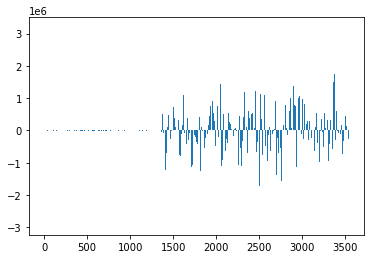

In [13]:
importance = lm.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [5]:
selector = SelectFromModel(estimator=linear_model.LinearRegression(),max_features = 500).fit(x_train, y_train)
selector.estimator_.coef_

array([ 2.39347381e+03,  3.69545961e+03,  1.34478841e+03, ...,
       -1.45976784e+06,  1.18080530e+06, -2.75373684e+05])

In [6]:
feature_idx = selector.get_support()
feature_name = x_train.columns[feature_idx]

In [7]:
selector.threshold_

322177.18925551174

In [8]:
x_train = selector.transform(x_train)
x_test = selector.transform(x_test)

### Defining different functions to ease the process

During the project, we will be using three most popular methods which are the as the followings: 
1. Random Forest
2. Gradient Boosting
3. Support Vector Machines

We define different functions in order to facilitate the process of training part, by using these functions, it is only necessary to give three arguments: 
1. Training set
2. Testing set 
3. The different values that we want to tune for the hyperparameters

In [17]:
# 1. Random forest
def optimize_rf(x_train, y_train, params_rf):
    rf=RandomForestRegressor(random_state = 10)
    rf_search = RandomizedSearchCV(rf, params_rf, cv=custom_cv, n_iter = 30)
    rf_search.fit(x_train, y_train)
    return rf_search.best_estimator_

In [18]:
# 2. Gradient boosting
def optimize_gb(x_train, y_train, params_gb):
    gb=GradientBoostingRegressor(random_state = 10)
    gb_search = RandomizedSearchCV(gb, params_gb, cv=custom_cv, n_iter = 30)
    gb_search.fit(x_train, y_train)
    return gb_search.best_estimator_

In [19]:
# 3. SVM
def optimize_svm(x_train, y_train, params_svm):   
    svm = SVR()
    svm_search = RandomizedSearchCV(svm, params_svm, cv=custom_cv, n_iter = 30)
    svm_search.fit(x_train, y_train)
    return svm_search.best_estimator_

With the intention of visualization of the different results of metrics per model, we create a matrix that displays all the results of each model per each data set that we modify. 


Also, it is necessary to create a function that automatically does the imputation in the matrix for us. 

The function made requires 5 arguments: the true reponse (y element) for training set and testing set; the prediction of the response that the different models have made and the name of the model. 

#### 1.1 Random Forest

For random forest, we tune 4 different hyperparameters: 
- max_depth which is the maximum number of levels in each decision tree, we tune it randomly in range $[4, 7)$;
- min_samples_leaf which is the minimum number of instances allowed in a leaf node, we tune it randomly in range $[4, 12)$;
- n_estimators which is the number of trees in the forest, we tune it randomly in range $[130, 280)$;
- and max_features which is the maximum number of features considered for splitting a node, we tune it randomly in range $[25, 38)$

In [20]:
start_rf = time.time()

params_rf = {'max_depth': sp_randint(3, 6), 'min_samples_leaf': sp_randint(30, 50),
             'n_estimators': sp_randint(500, 600), 'max_features': sp_randint(110, 210)}
rf1 = optimize_rf(x_train, y_train, params_rf)

end_rf = time.time()
time_rf = end_rf - start_rf

In [21]:
time_rf

3697.4661819934845

The best hyperparameters for the random forest model are as follows:


In [22]:
rf1

RandomForestRegressor(max_depth=5, max_features=124, min_samples_leaf=33,
                      n_estimators=577, random_state=10)

In [23]:
rf1_pred_train = rf1.predict(x_train)
rf1_pred_test = rf1.predict(x_test)

In [24]:
metrics(y_train, rf1_pred_train, y_test, rf1_pred_test, 'RF')

explained variance of training set: 0.8438882460116552
explained variance of testing set: 0.8063085663997978
maximum error of training set: 385155.0960054205
maximum error of testing set: 327287.571330486
mae of training set: 63813.12022005345
mae of testing set: 74013.14538818001
mse of training set: 6286240147.534252
mse of testing set: 8408071458.377964
rmse of training set: 79285.81302814679
rmse of testing set: 91695.53674186091


#### 1.2 Gradient Boosting

For gradient boosting, we tune 4 different hyperparameters: 

- learning_rate determines the weight of each tree added to the global model, we tune it randomly in range $(0.0001, 0.6)$;
- n_estimators which is the number of trees in the forest, we tune it randomly in range $[180, 300)$;
- max_depth which is the maximum number of levels in each decision tree, we tune it randomly in range $[4, 8)$;
- min_samples_leaf which is the minimum number of instances allowed in a leaf node, we tune it randomly in range $[4, 10)$;

In [43]:
start_gb = time.time()

params_gb = {'learning_rate': loguniform(0.0001, 0.3), 'n_estimators':sp_randint(800, 900),
             'max_depth':sp_randint(3, 5), 'min_samples_leaf':sp_randint(50, 60)}
gb1 = optimize_gb(x_train, y_train, params_gb)

end_gb = time.time()
time_gb = end_gb - start_gb

In [44]:
time_gb

24765.69676065445

In [45]:
gb1

GradientBoostingRegressor(learning_rate=0.1296704275012188, min_samples_leaf=56,
                          n_estimators=875, random_state=10)

In [46]:
gb1_pred_train = gb1.predict(x_train)
gb1_pred_test = gb1.predict(x_test)

Training by gradient boosting using all the variables, we can get the following conclusions: 
- The model has the explained variance of 90.9%, and the rmse of 276, comparing the results to rf, gb works a slightly better
- But the difference of the results for training set and testing set is also higher, there might be the overfitting problem

In [47]:
metrics(y_train, gb1_pred_train, y_test, gb1_pred_test, 'GB')

explained variance of training set: 0.9920438488237564
explained variance of testing set: 0.9449043888896377
maximum error of training set: 117210.01193731988
maximum error of testing set: 415134.3841466903
mae of training set: 13961.99874727934
mae of testing set: 35850.24342987483
mse of training set: 320373136.71352875
mse of testing set: 2394123384.099614
rmse of training set: 17898.970269642014
rmse of testing set: 48929.780135410525


#### 1.3 Support Vector Machine

For support vector machine method, we tune 3 different hyperparameters: 

- kernel, it is a function used so that the data points become linearly separable, it is set to be rbf.
- C, C parameter adds a penalty for each misclassified data point.
- gamma, gamma parameter of RBF controls the distance of influence of a single training point

In [30]:
start_svm = time.time()

params_svm = {'C': loguniform(10e-5, 10e+5),
              'gamma': loguniform(10e-5, 10e+1),
              'kernel': ['rbf']}
svm1 = optimize_svm(x_train, y_train, params_svm)

end_svm = time.time()
time_svm = end_svm - start_svm

In [31]:
time_svm

1249.3432853221893

The best hyperparameters for SVM model are as follows:

In [32]:
svm1

SVR(C=237152.19312547756, gamma=0.0005960901326120019)

In [33]:
svm1_pred_train = svm1.predict(x_train)
svm1_pred_test = svm1.predict(x_test)

In [34]:
metrics(y_train, svm1_pred_train, y_test, svm1_pred_test, 'SVM')

explained variance of training set: 0.9996825920495129
explained variance of testing set: 0.9051340906843413
maximum error of training set: 105434.75884964934
maximum error of testing set: 432082.43999534554
mae of training set: 490.21417559451396
mae of testing set: 46495.087755608976
mse of training set: 12786019.09738511
mse of testing set: 4140854215.148748
rmse of training set: 3575.7543396303263
rmse of testing set: 64349.46942398786


In [39]:
lm = linear_model.LinearRegression()
lm.fit(x_train, y_train)

LinearRegression()

In [40]:
lm_pred_train = lm.predict(x_train)
lm_pred_test = lm.predict(x_test)

In [41]:
metrics(y_train, lm_pred_train, y_test, lm_pred_test, 'lm')

explained variance of training set: 0.8240810699941004
explained variance of testing set: 0.7753089604332568
maximum error of training set: 448402.1170062296
maximum error of testing set: 359200.2118384704
mae of training set: 65958.14547891656
mae of testing set: 77345.33346069153
mse of training set: 7083789405.807597
mse of testing set: 9776362810.685795
rmse of training set: 84165.25058364407
rmse of testing set: 98875.49145610248


Training by support vector machine using all the variables, we can find out that it did not work pretty well due to the fact that it needs more computer cost in order to get more precission. Due to the condition that we have, we will just leave it like that. 

In [48]:
df_metricas

,train_R2,test_R2,train_MAXerror,test_MAXerror,train_mae,test_mae,train_mse,test_mse,train_rmse,test_rmse
RF,0.843888,0.806309,385155,327288,63813.1,74013.1,6.28624e+09,8.40807e+09,79285.8,91695.5
GB,0.992044,0.944904,117210,415134,13962,35850.2,3.20373e+08,2.39412e+09,17899,48929.8
SVM,0.999683,0.905134,105435,432082,490.214,46495.1,1.2786e+07,4.14085e+09,3575.75,64349.5
lm,0.824081,0.775309,448402,359200,65958.1,77345.3,7.08379e+09,9.77636e+09,84165.3,98875.5
lm_all_vars,0.980394,0.925096,184837,396570,21766.9,44624,7.8947e+08,3.32585e+09,28097.5,57670.2


In [36]:
time_running = pd.DataFrame(columns=['time_to_run'], 
                         index=['RF_all','GB_all','SVM_all'])

In [37]:
time_running.loc['RF_all','time_to_run']=time_rf
time_running.loc['GB_all','time_to_run']=time_gb
time_running.loc['SVM_all','time_to_run']=time_svm

Observing this table which contains the time spent runing using all the variables, we can see that gradient boosting method has taken the longest time to finish runing, but also it worked the best.

In [38]:
time_running

,time_to_run
RF_all,3697.47
GB_all,23388
SVM_all,1249.34


################################################

## Feature Importance

################################################

In [9]:
# Libraries used
# permutation test
import eli5
from eli5.sklearn import PermutationImportance

# Partial Dependence test
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

# Shap values
import shap

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\Admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [10]:
gb1 = GradientBoostingRegressor(learning_rate=0.1296704275012188, min_samples_leaf=56,
                          n_estimators=875, random_state=10)
gb11 = gb1.fit(x_train, y_train)
gb1_pred_train = gb11.predict(x_train)
gb1_pred_test = gb11.predict(x_test)

### Permutation Importance

##### 1. permutation test for the best model (gradient boosting)

In [13]:
perm = PermutationImportance(gb11, random_state=10).fit(x_test, y_test)
eli5.show_weights(perm, feature_names = feature_name.tolist())

Weight,Feature
0.0637 ± 0.0021,u100_41.0_-1.0
0.0323 ± 0.0010,v100_42.5_-4.0
0.0265 ± 0.0035,u100_42.0_-5.5
0.0181 ± 0.0018,u100_38.5_-1.5
0.0170 ± 0.0015,u100_37.5_-2.5
0.0164 ± 0.0021,v100_42.5_-1.0
0.0085 ± 0.0008,v100_41.0_-4.5
0.0067 ± 0.0010,v100_41.5_-1.5
0.0061 ± 0.0007,u100_41.0_-9.5
0.0057 ± 0.0007,u100_36.0_-5.0


### Partial Dependence Plots

It shows by plot how will the predicted value change if we change a single variable in the data set.
The y axis is interpreted as change in the prediction from what it would be predicted at the baseline (the original prediction).
The blue shaded area show the area of confidence interval. 

In [20]:
x = pd.DataFrame(x_test)
x.columns = feature_name

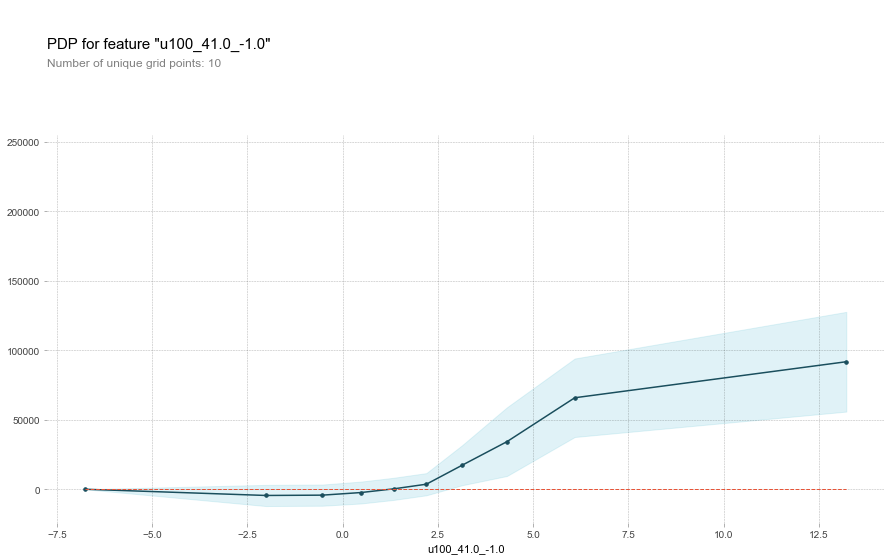

In [24]:
# 'norma_100_36.0_-6.0' most important variable according permutation test
# Create the data that we will plot
pdp_u100 = pdp.pdp_isolate(model=gb11, dataset= x, model_features=feature_name, feature='u100_41.0_-1.0')

# plot it
pdp.pdp_plot(pdp_u100, 'u100_41.0_-1.0')
plt.show()

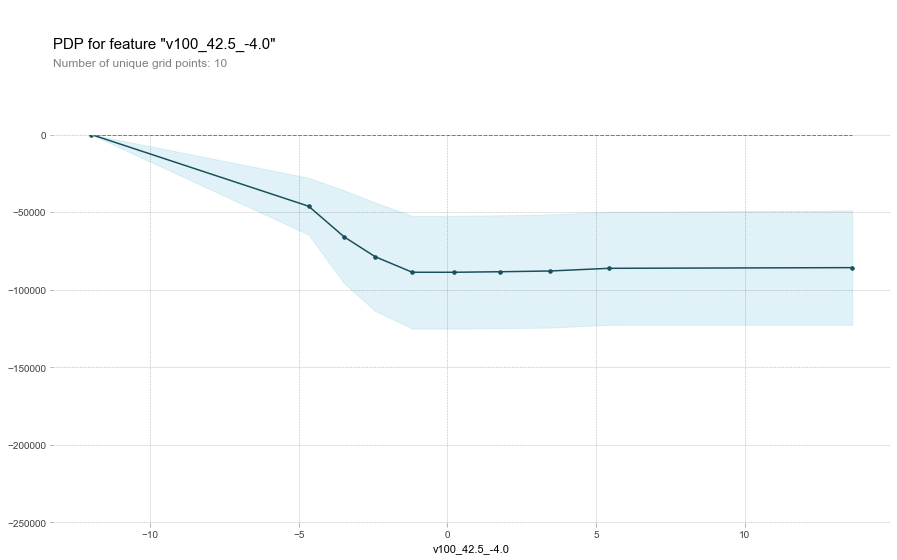

In [25]:
# 2nd most important variable according to permutation test
pdp_v100 = pdp.pdp_isolate(model=gb11, dataset=x, model_features=feature_name, feature='v100_42.5_-4.0')

pdp.pdp_plot(pdp_v100, 'v100_42.5_-4.0')
plt.show()

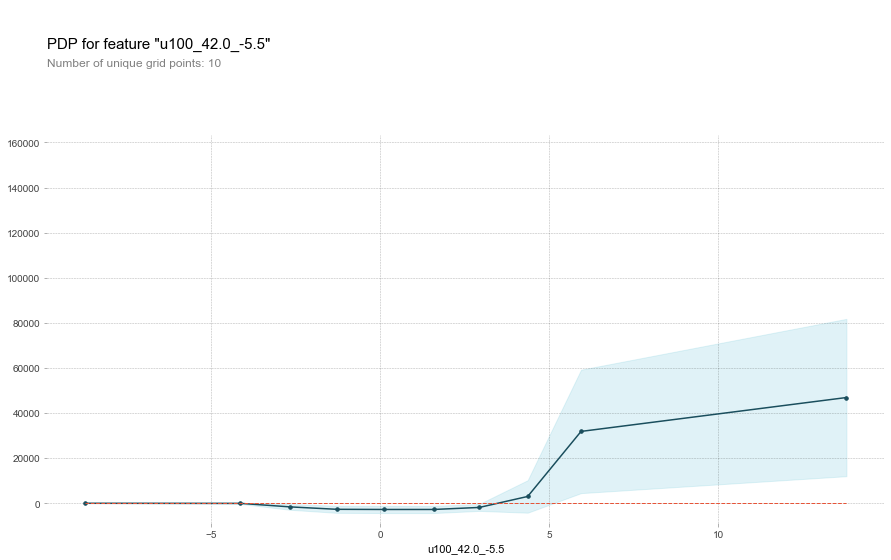

In [26]:
pdp_u100_2 = pdp.pdp_isolate(model=gb11, dataset=x, model_features=feature_name, feature='u100_42.0_-5.5')

pdp.pdp_plot(pdp_u100_2, 'u100_42.0_-5.5')
plt.show()

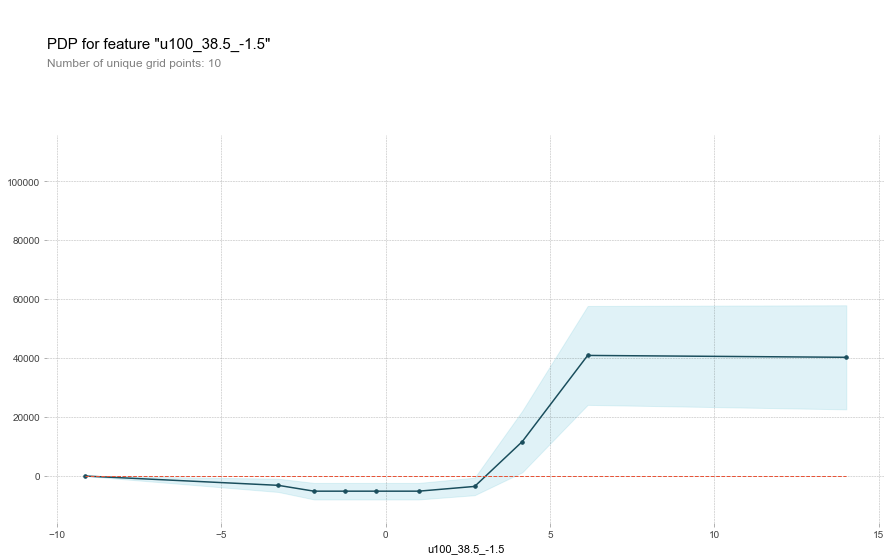

In [27]:
pdp_u100_2 = pdp.pdp_isolate(model=gb11, dataset=x, model_features=feature_name, feature='u100_38.5_-1.5')

pdp.pdp_plot(pdp_u100_2, 'u100_38.5_-1.5')
plt.show()

The PDP plot of interaction between the previous 2 variables shows exactly the conclusions we have had before. The energy production hits the peak when having the lowest u component on coordinate (36.0, -5.0) with the highest module on coordinate (36.0, -6) (yellow area), and it is the minimum when there are higher values of u component on (36.0, -5.0) and lower values of the variable module on (36.0, -6) (purple area). 

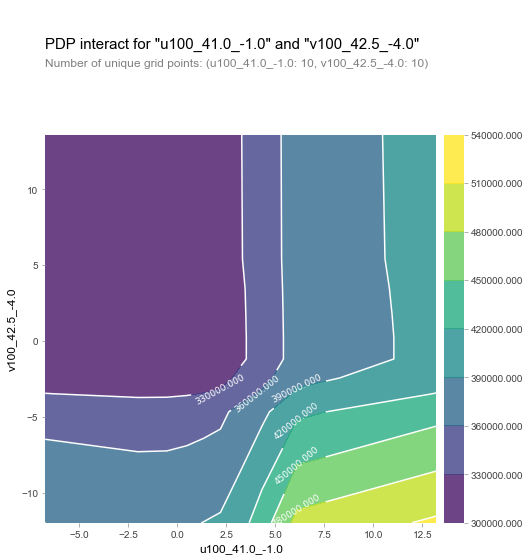

In [28]:
# Interaction between them 

pdp_inter = pdp.pdp_interact(model=gb11, dataset=x, model_features=feature_name, features=['u100_41.0_-1.0','v100_42.5_-4.0'])

pdp.pdp_interact_plot(pdp_interact_out = pdp_inter, feature_names = ['u100_41.0_-1.0','v100_42.5_-4.0'], plot_type = 'contour')
plt.show()

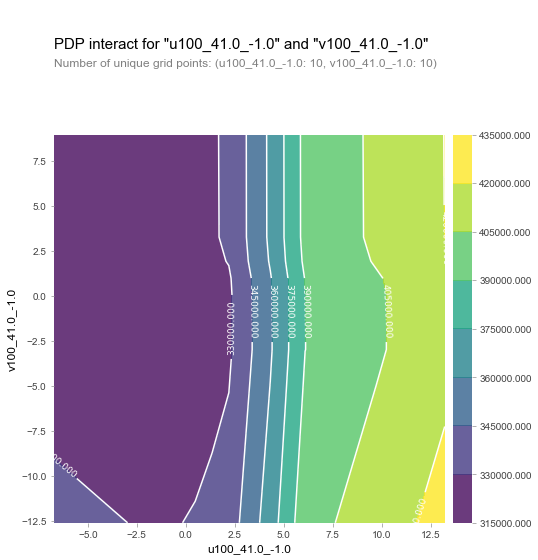

In [29]:
# Interaction between them 

pdp_inter2 = pdp.pdp_interact(model=gb11, dataset=x, model_features=feature_name, features=['u100_41.0_-1.0','v100_41.0_-1.0'])

pdp.pdp_interact_plot(pdp_interact_out = pdp_inter2, feature_names = ['u100_41.0_-1.0','v100_41.0_-1.0'], plot_type = 'contour')
plt.show()

### SHAP values 

In [31]:
data_for_prediction = x.iloc[20]

In [32]:
data_for_prediction.values.reshape(1, -1).shape

(1, 500)

In [33]:
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

gb11.predict(data_for_prediction_array)

array([697045.94249307])

In [34]:
explainer = shap.TreeExplainer(gb11)
shap_values = explainer.shap_values(data_for_prediction)

In [35]:
shap_values

array([-8.71230090e+02, -1.55177113e+03,  7.60106033e+02,  9.95262048e+01,
        3.71802234e+01, -1.14136367e+02,  1.85633167e+01,  3.25673914e+01,
       -1.51498775e+02,  2.61773490e+01,  6.83680443e+00,  6.73994222e+00,
        2.76539564e+01,  8.37846841e+00,  1.41391052e+02, -5.34369613e+01,
       -1.78678600e+03, -1.68864707e+02, -1.94487630e+02,  1.35328097e+02,
        3.77464827e+00,  1.44315244e+03, -5.07194859e+03, -2.88949898e+02,
        4.16033933e+02,  0.00000000e+00,  2.80227784e+02,  5.38891348e+02,
       -1.96260389e+03,  1.75802741e+02,  3.63550889e+01,  7.63779368e+02,
       -4.83142511e+02,  1.06862607e+02, -5.27716456e+00, -8.59835986e+02,
       -4.98040127e+02, -1.06495314e+03, -2.07779872e+02,  5.34158110e+02,
        6.18980721e+01, -4.03722550e+01, -1.26395279e+02,  1.19472903e+02,
        5.38656636e+02,  8.42716718e+01,  1.00487242e+02, -1.07791333e+02,
       -1.76132637e+02, -2.43914679e+01, -1.08681253e+02,  2.58299853e+02,
        1.43323816e+02, -

In [36]:
explainer.expected_value

array([341320.31656718])

It is obvious to observe in pink part that, the variable that has most impact on the prediction is precisely the most important variable on permutation test done before, and this module on coordinate (36.0, -6) increases the prediction.

In [37]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

### Advanced Uses of SHAP values

#### Summary Plots

This plot makes a summary of permutation importance and partial dependence plot. It is very clear to see that, when higher value of module on (36.0, -6) (according to the line on the right, the color of the points is warmer), higher the energy production; as for u component on (36.0, -5.0), when lower value of it, the energy production becomes higher (points with colder color tend to have higher SHAP value). 

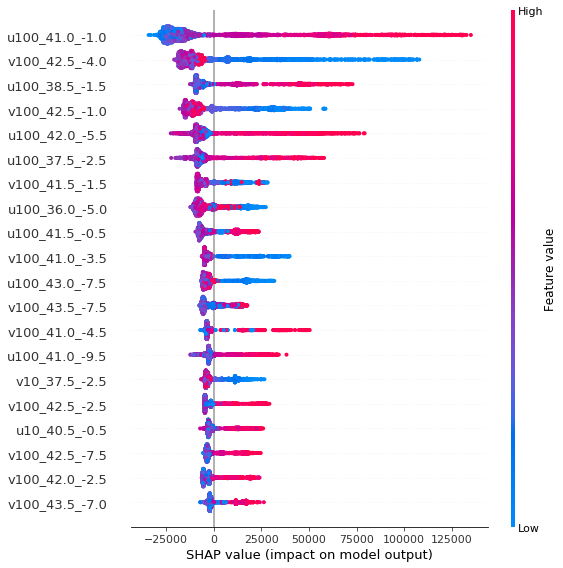

In [40]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(gb11)

# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(x)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values, x)

#### SHAP Dependence Contribution Plots

From this plot, we can see that in general, having higher module in coordinates (36, -6) increases the energy production. The critical values for the variable is around 10, if the module is smaller than 10, having higher u100 component in (36, -6) will decrease the the production while if it’s higher than 10, higher u100 component in (36, -6) will increase the energy production.

In [ ]:
'u100_41.0_-1.0','v100_42.5_-4.0'

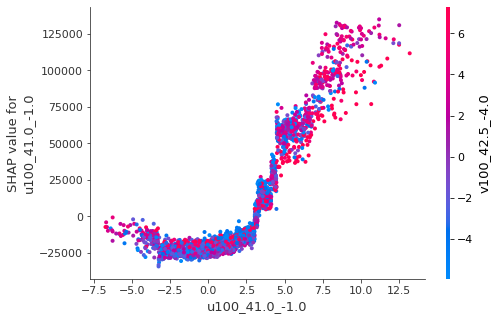

In [42]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(gb11)

# calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(x)

# make plot.
shap.dependence_plot('u100_41.0_-1.0', shap_values, x, interaction_index='v100_42.5_-4.0')

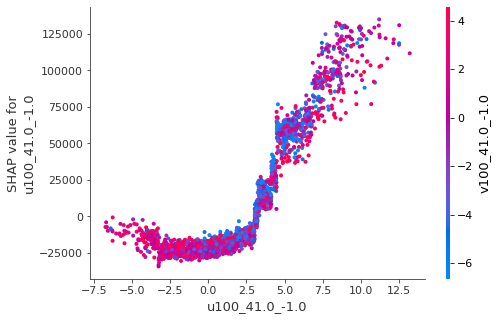

In [43]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(gb11)

# calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(x)

# make plot.
shap.dependence_plot('u100_41.0_-1.0', shap_values, x, interaction_index='v100_41.0_-1.0')